# Modelling the Annual Revenue of the UBC Blue Chip Cafe

## Problem Statement

In this project, we would construct a stochastic model to analyze how daily temperature and precipitation influence the daily revenue for the UBC Blue Chip Cafe.

The Blue Cafe has access to the following data:

* Daily average temperature (in degrees Celsius) from January 1, 1997 through December 31, 2022.
* Daily precipitation (in millimeters) from January 1, 1997 through December 31, 2022.
* Total frequency of customers in the month of March 2024 for each hour of operation.

We would use the datas above to construct a stochastic models which describes how revenue change based on weather.

## Variables and Parameters

Below are the variables and parameters for this modelling project.

| Description | Symbol | Dimension | Type |
| :----: | :--: | :--: | :---: |
|the total daily customers| C | 1 | Dependent Variable |
|the average daily temperature| T | $^{\circ}$C | Independent Variable |
|the total daily precipitation| P | mm of water | Independent Variable |
|the reference number of customers| $C_{0}$ | 1 |Parameter|
|the reference daily temperature| $T_{0}$ | $^{\circ}$C|Parameter|
|the reference precipitation|$P_{0}$|mm of water|Parameter|
|Rate of change of customers with respect to temperature|a|1/$^{\circ}$C|Parameter|
|Rate of change of customers with respect to precipitation|b|1/mm of water|Parameter|
|price of one drinks| $P_{d}$| Dollars| Parameter|
|price of one cookies| $P_{c}$| Dollars| Parameter|
|cost of one drinks| $K_{d}$| Dollars| Parameter|
|cost of one cookies| $K_{c}$| Dollars| Parameter|

## Assumptions and Constraints

* The prices of items are the same from 1997 to 2022.
* Each customer only purchases 1 pastry and 1 drink.

We use the online menu of Blue Chip Cafe to get the prices of products. 
* The average price of a piece of pastry are the same and equal to 3 dollars.
* The average price of drinks equal to 5.12 dollars.
* In total, every customer spends 8.12 dollars.
* There are no disruptions to service.
* The cost of making one cup of coffee is \\$1.84, including the cost of coffee, milk, water, work of an employee, electricity, and rentals. The price for cookies is \\$1.896 (Arias, 2024).
* The business always has more cookies and drinks available to sell.
* Opening hours are the same for the entire period.
* Only weather (temperature and precipitation) influences the amount of customers served.

## Building Solutions

After analyzing the data, the owner of UBC Blue Chip have determined that the number of customers has the form
$$C(T,P) = \max \{c(T,P),0 \}$$ 

$$c(T,P) = C_0 +a(T −T_0)−b(P −P_0)$$

Where 

* the total daily customers is $C$
* the average daily temperature is $T$
* the total daily precipitation is $P$
* the reference number of customers is $C_{0}$
* the reference temperature is $T_{0}$
* the reference precipitation is $P_{0}$
* the rate of change of customers with respect to temperature is $a$
* the rate of change of customers with respect to precipitation is $b$

In [2]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

In [3]:
customer = pd.read_csv('customer.csv')
weather = pd.read_csv('vancouver_weather.csv')

T = weather['avg_temperature']
P = weather['precipitation']

### Finding $P_{0}$ and $T_{0}$

Since mean is a representative measure of the data and centers the models around the most common weather conditions, we will set $P_{0}$ the reference precipitation to the mean average precipitation from 1997 to 2022. $T_{0}$, the reference temperature, will equal to the mean average tmperature from 1997 to 2022.

In [4]:
T0 = np.mean(T)
P0 = np.mean(P)

In [5]:
print("TO = ", T0)
print("PO = ", P0)

TO =  10.582639005897219
PO =  3.2037068239258635


Next, we will use the kernel density function to create a PDF for the temperature and precipication datas.

### PDF of Temperatures

In [6]:
pdf_temp = stats.gaussian_kde(T)

In [7]:
x = np.linspace(-15,30,1000)

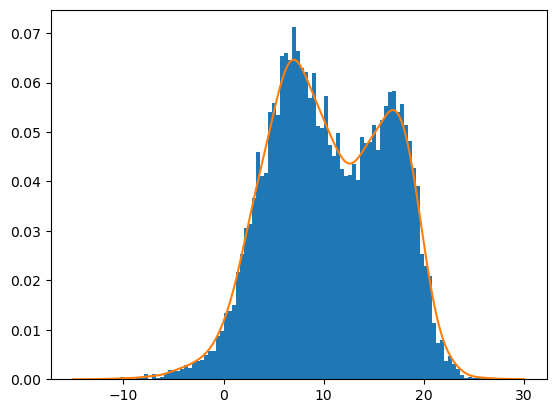

In [8]:
plt.hist(T, bins=100, density = True)
plt.plot(x,pdf_temp(x))
plt.show()

### PDF of Precipications

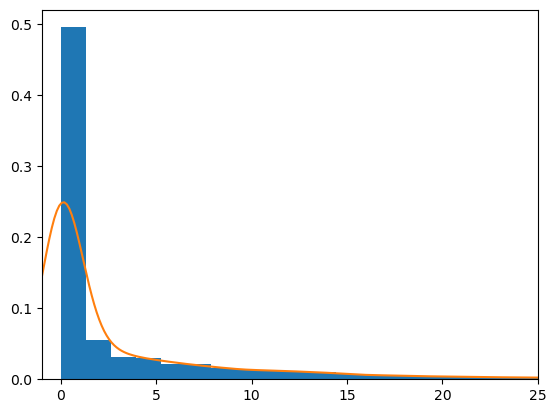

In [9]:
pdf_prep = stats.gaussian_kde(P)
x2 = np.linspace(-1,25,200)
plt.hist(P, bins=70, density = True)
plt.plot(x2,pdf_prep(x2))
plt.xlim([-1,25])
plt.show()

### Finding $C_{0}$

To calculate $C_0$, we will sum the customer numbers in the month of March and divide by 31 to obtain the daily reference customer count.

In [10]:
C0 = np.sum(customer['Monthly_Frequency_Customers'])/31 # Daily average
print("CO = ", C0)

CO =  185.2258064516129


### Determining a and b

- We can find $a$ using $\Delta C / \Delta T$. Given the customer count data for March 2024, we assume a 20% quantile for March and build a normal distribution based on this assumption. We consider a normal distribution appropriate because customer counts generally increase with temperature, peaking around June and July and decreasing in January and December, as shown in the graph above. Next, we calculate the difference between the tail and head values, denoted as $\Delta C$. Then, we group the weather data by year and month to obtain the monthly temperature difference, which we multiply by 12 to estimate the yearly temperature change, $\Delta T$.
- We find $b$ in a similar way for $\Delta C / \Delta P$.

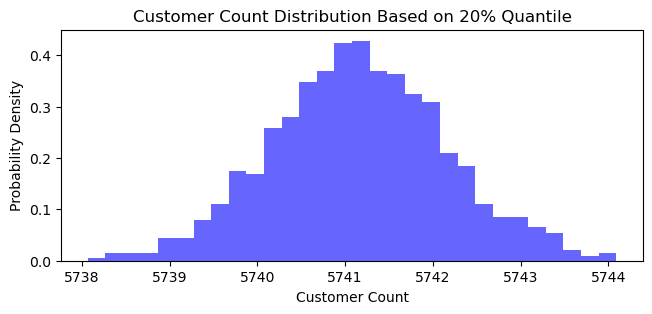

In [11]:
# Given customer count in March
customers_march = C0*31

# Assuming 5742.0 is the 20th percentile in a normal distribution
quantile = 0.20

# Calculate the mean and standard deviation for the distribution
# We assume a standard normal distribution, then solve for the parameters
mean, std_dev = stats.norm.ppf(quantile, loc=customers_march, scale=1), 1  # start with std deviation as 1

# Adjust to reflect the assumption based on 20th quantile
std_dev = (mean - customers_march) / stats.norm.ppf(quantile)

# Generate a normal distribution based on these parameters
distribution = np.random.normal(loc=mean, scale=std_dev, size=1000)

plt.figure(figsize=(7.5, 3))
plt.hist(distribution, bins=30, density=True, alpha=0.6, color='b')
plt.title("Customer Count Distribution Based on 20% Quantile")
plt.xlabel("Customer Count"); plt.ylabel("Probability Density")
plt.show()

We found $a$ and $b$ to be approximately $2.9$ and $0.99$, respectively. We now use the customer data (total monthly customers and daily average) to compare the $a$ and $b$ parameters. 

In [55]:
## Parameter Values
a = 2.99    # Rate of change wrt temperature
b = 0.99   # Rate of change wrt precipitation
avg_purchase = 8.12  # Average revenue per customer

### Revenue Function

First, let's constructed a deterministic model to calculate the average monthly revenue of Blue Chip Cafe.

In [59]:
## Customers function
c = lambda t,p: C0 + a*(T0 - t) - b*(p - P0)

def Customers_in_period(temp,pre):
    customs = []
    for k in range(len(temp)):
        DayCustomer = max(c(temp[k],pre[k]),0)
        customs.append(DayCustomer)
    return customs

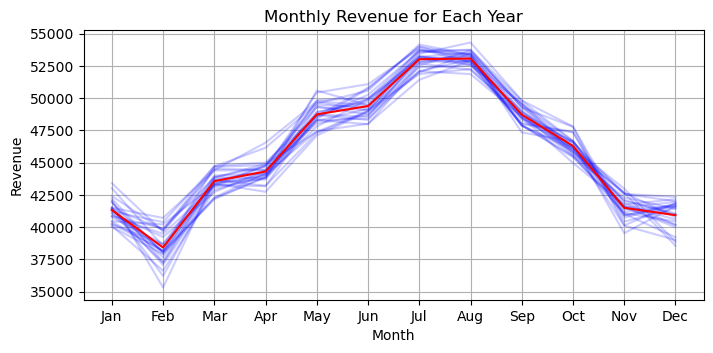

In [60]:
def period_revenue(data):
    T = data['avg_temperature']
    P = data['precipitation']
    c = C0 + a*(T - T0) - b * (P - P0)
    c = np.maximum(c,0)
    rev = np.sum(c) * 8.12
    return rev

monthly_revenue = {} # Calculate revenue per month
for year in range(1997, 2023):
    yearly_data = weather[weather['year'] == year]
    monthly_data = yearly_data.groupby('month')
    monthly_revenue[year] = {month: period_revenue(month_data) for month, month_data in monthly_data}

# Convert monthly revenue to DataFrame for easier plotting
monly_rev_df = pd.DataFrame(monthly_revenue).T

plt.figure(figsize=(8, 3.5)) # Plot revenue for each year
for year in monly_rev_df.index:
    plt.plot(monly_rev_df.columns,monly_rev_df.loc[year],color='blue',alpha=0.2)

## monthly_average
monthly_avg = [np.mean(monly_rev_df[month]) for month in monly_rev_df.columns]
monly_rev_df.loc['Month_Average'] = monthly_avg
plt.plot(monly_rev_df.columns, monly_rev_df.loc['Month_Average'], color = 'red')

plt.xlabel('Month'); plt.ylabel('Revenue'); plt.grid()
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Monthly Revenue for Each Year')
plt.show()

In [61]:
## Calculate for annual revenue
monly_rev_df['annual'] = pd.DataFrame.sum(monly_rev_df,axis=1)
Ann_rev = monly_rev_df['annual']
Ann_rev = Ann_rev.tolist()
Anual_avg = Ann_rev[-1]
Annual_min = np.min(Ann_rev); Annual_max = np.max(Ann_rev)

print(f"Annual Average Revenue: ${Anual_avg}")
print(f"Annual Minimum Revenue: ${Annual_min}")
print(f"Annual Maximum Revenue: ${Annual_max}")

Annual Average Revenue: $549319.3298263027
Annual Minimum Revenue: $544011.1044650164
Annual Maximum Revenue: $557675.3761999232


Next, let's incorporate variability into our model by constructing a stochastic models for the annual revenue of the Blue Chip Cafe.

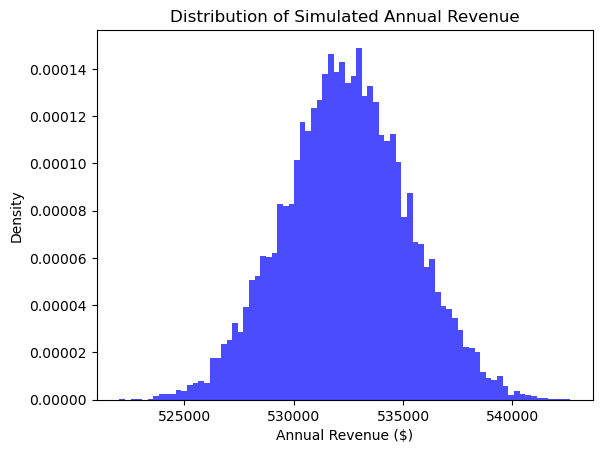

In [75]:
N_simulations = 10000
annual_revenue = []
N_days = 365 - 11

for _ in range(N_simulations):
    T_sim = pdf_temp.resample(N_days).flatten()
    P_sim = pdf_prep.resample(N_days).flatten()
    C_sim = C0 + a * (T_sim - T0) + b * (P_sim - P0)
    C_sim = np.maximum(C_sim, 0)  # Ensure non-negative customers
    daily_revenue = C_sim * avg_purchase
    annual_revenue.append(np.sum(daily_revenue))

# Plot distribution of annual revenue
plt.hist(annual_revenue, bins=80, density=True, alpha=0.7, color='blue')
plt.title('Distribution of Simulated Annual Revenue')
plt.xlabel('Annual Revenue ($)')
plt.ylabel('Density')
plt.show()

Let's print out the mean annual revenue and range of the annual revenue.

In [73]:
# Print summary statistics
print(f"Mean Revenue: ${np.mean(annual_revenue)}")
print(f"Revenue Range: ${np.min(annual_revenue)} ~ ${np.max(annual_revenue)}")

Mean Revenue: $532426.796536943
Revenue Range: $521670.9552302596 ~ $543603.7364596555


The Mean Annual Revenue for our deterministic model is 549319.30 dollars and 532426.80 dollars for the stochastic model. The maximum annual revenue for the deterministic model 557675.40 dollars and 543603.70 for the stochastic model. The minimum annual revenue for the deterministic model 544011.10 dollars and 521670.96 dollar for the stochastic model. Although there were some difference in values between the stochastic and deterministic model, the results between the two models were similar.

### Income Function

Next, we will calculate the net income of the Blue Chip Cafe by subtracting the operation cost from the Revenue. 

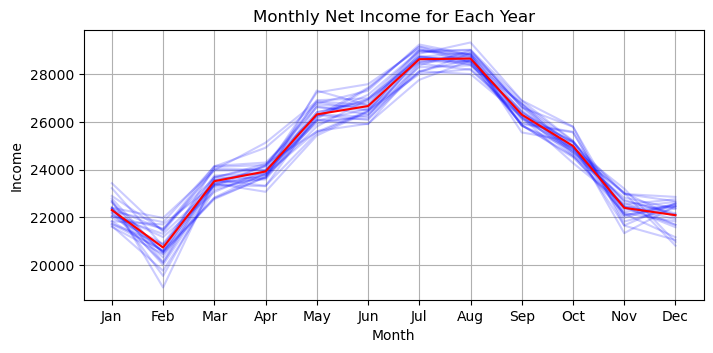

In [83]:
def period_income(data):
    T = data['avg_temperature']
    P = data['precipitation']
    c = C0 + a*(T - T0) - b * (P - P0)
    c = np.maximum(c,0)
    rev = np.sum(c) * 8.12
    income = rev - np.sum(c) * (1.84 + 1.896)
    return income

monthly_income = {} # Calculate revenue per month
for year in range(1997, 2023):
    yearly_data = weather[weather['year'] == year]
    monthly_data = yearly_data.groupby('month')
    monthly_income[year] = {month: period_income(month_data) for month, month_data in monthly_data}

# Convert monthly revenue to DataFrame for easier plotting
monly_rev_df = pd.DataFrame(monthly_income).T

plt.figure(figsize=(8, 3.5)) # Plot revenue for each year
for year in monly_rev_df.index:
    plt.plot(monly_rev_df.columns,monly_rev_df.loc[year],color='blue',alpha=0.2)

## monthly_average
monthly_avg = [np.mean(monly_rev_df[month]) for month in monly_rev_df.columns]
monly_rev_df.loc['Month_Average'] = monthly_avg
plt.plot(monly_rev_df.columns, monly_rev_df.loc['Month_Average'], color = 'red')

plt.xlabel('Month'); plt.ylabel('Income'); plt.grid()
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Monthly Net Income for Each Year')
plt.show()

In [84]:
## Calculate annual profits
monly_rev_df['annual'] = pd.DataFrame.sum(monly_rev_df,axis=1)
Ann_rev = monly_rev_df['annual']
Ann_rev = Ann_rev.tolist()
Anual_avg = Ann_rev[-1]
Annual_min = np.min(Ann_rev); Annual_max = np.max(Ann_rev)
print(f"Annual Average Net Income: ${Anual_avg}")
print(f"Annual Minimum Net Income: ${Annual_min}")
print(f"Annual Maximum Net Income: ${Annual_max}")

Annual Average Net Income: $296578.31797518604
Annual Minimum Net Income: $293712.39925795957
Annual Maximum Net Income: $301089.7597611409


For the net income, let's also run stochastic simulations to determine the average annual net income and range of annual net income.

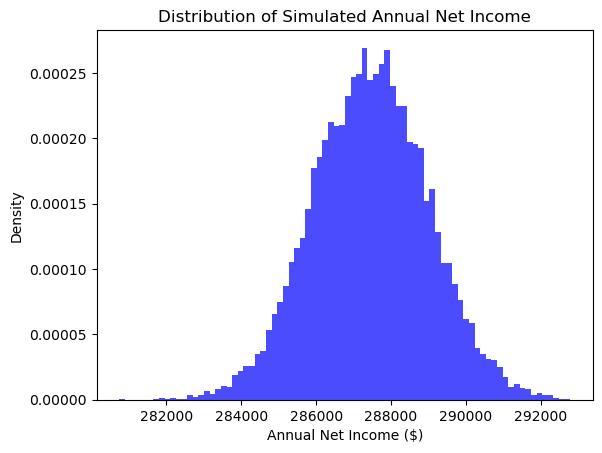

In [85]:
N_simulations = 10000
annual_nincome = []
N_days = 365 - 11

for _ in range(N_simulations):
    T_sim = pdf_temp.resample(N_days).flatten()
    P_sim = pdf_prep.resample(N_days).flatten()
    C_sim = C0 + a * (T_sim - T0) + b * (P_sim - P0)
    C_sim = np.maximum(C_sim, 0)  # Ensure non-negative customers
    rev = np.sum(C_sim) * 8.12
    daily_income = rev - np.sum(C_sim)*(1.84 + 1.896)
    annual_nincome.append(np.sum(daily_income))

# Plot distribution of annual revenue
plt.hist(annual_nincome, bins=80, density=True, alpha=0.7, color='blue')
plt.title('Average Annual Net Income')
plt.xlabel('Annual Net Income ($)')
plt.ylabel('Density')
plt.show()

In [86]:
# Print summary statistics
print(f"Mean Net Income: ${np.mean(annual_nincome)}")
print(f"Net Income Range: ${np.min(annual_nincome)} ~ ${np.max(annual_nincome)}")

Mean Net Income: $287452.99801911437
Net Income Range: $280748.21798737376 ~ $292784.7018089103


The annual average net income follows a similar trend with the annual revenue.

## Plotting the Average Monthly Temperature and Average Monthly Precipitation

Let's plot the Average Monthly tempeature and precipitation from 1997 to 2022.

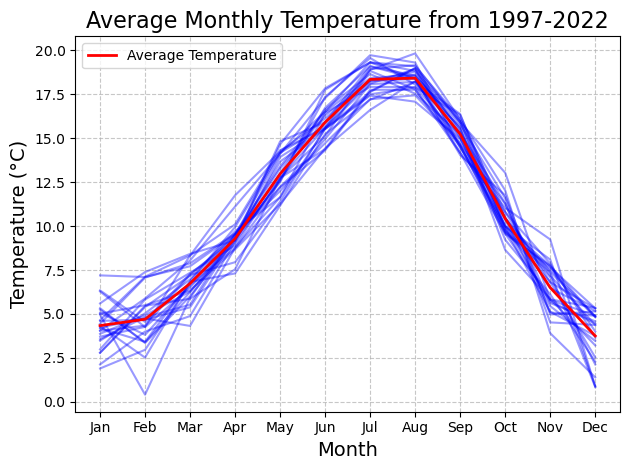

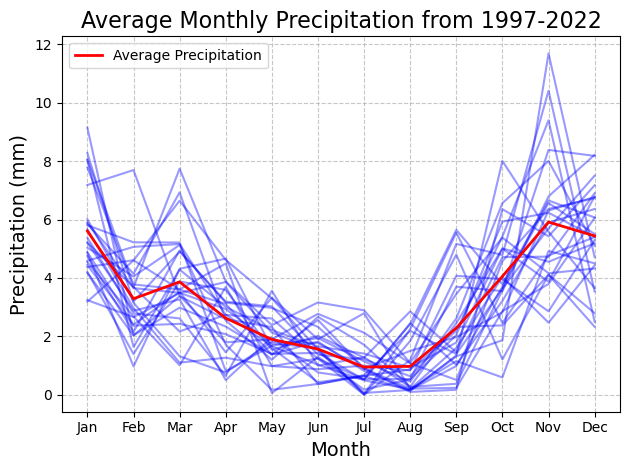

In [19]:
# Group data by year and month to calculate monthly averages
monthly_averages = weather.groupby(['year', 'month']).mean().reset_index()

# Create pivot tables for temperature and precipitation
temperature_pivot = monthly_averages.pivot(index='month', columns='year', values='avg_temperature')
precipitation_pivot = monthly_averages.pivot(index='month', columns='year', values='precipitation')

# Calculate the overall average for each month
average_temperature = temperature_pivot.mean(axis=1)
average_precipitation = precipitation_pivot.mean(axis=1)

# Plot average monthly temperature across years
plt.plot(temperature_pivot.index, temperature_pivot, color='blue', alpha=0.4, label='_nolegend_')
plt.plot(temperature_pivot.index, average_temperature, color='red', linewidth=2, label='Average Temperature')
plt.title('Average Monthly Temperature from 1997-2022', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Plot average monthly precipitation across years
plt.plot(precipitation_pivot.index, precipitation_pivot, color='blue', alpha=0.4, label='_nolegend_')
plt.plot(precipitation_pivot.index, average_precipitation, color='red', linewidth=2, label='Average Precipitation')
plt.title('Average Monthly Precipitation from 1997-2022', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Precipitation (mm)', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Analyze and Assess

### Monthly Net Income and Revenue Analysis

For the annual revenue, the average annual revenue is 549,319.3 dollars for the deterministic model and 532426.80 dollar for the stochastic model. The range of the annual revenue is between 557,449.5 and 544,184 dollars for the deterministic model and between 521671 and 543603.70 for the stochastic model. 

The annual profit/net income is the annual revenue minus the operation cost.The annual average net income from the deterministic model is 296578.32 dollars and 287453.00 dollars for the stochastic model. The range of the annual net income is between 293712.40 and 301089.80 for the deterministic model and between 280748.22 and 292784.70 dollars for the stochastic model.

The average monthly net income starts out at around 22,500 dollars per month in Janurary and reaches the lowest point in Feburary at around 21,000 dollars. Feburary's net income also has more variance in revenue than revenues on other months. The net income steadily increases from the month of Febuary to August. The net income at the month of July and August is the highest point at around $28,400. Then, the income decreases overtime from the month of August to December. The the income in the month of December is similar to the monthly income on Janurary.

One reason the net revenue on December, Janurary, Feburary are low on these month could be due to colder weather and rain, which deters students from going to Blue Chip to buy coffee. This is reflected in the monthly average precipitation and temperature graphs. Temperatures on the month of December, Janurary, and Feburary are lower than the other months while precipciation levels are high. On the month of June, July, and August, precipciation levels are at an all time low while temperatures are at the highest point of the year. Hence, students would be more likely to go outside and purchase from stores. 

## Conclusions

- This study shows that precipication level and weather would influence revenue of the UBC Blue Chip Cafe. When precipication levels are high, the revenues of the Cafe are low. On the other hand, when temperature of the weather are high, revenue are high as well. Future research could study potential correlation between revenue, temperature, and precipication. 

- Janurary, Feburary, and December are times when the business is the least profitable while the Month of July and August is when the business is the most profitable. We could consider decreasing the price of our items on Feburary to attract more customers and increasing the price of the items on July and August to maximize profit. In addition, we could adjust the price of our items up in other months where the business is profitable and decreases the price of item on months where they aren't that profitable.

- For future models, we could include the customer choice for what and how many products to purchase, the associated costs for the cafe for each item sold (ingredients, paper cups, etc.), or varying prices for the menu items throughout time. Constructing a more realistic menu by adding uncertainty to price of goods to show a range of the expense each customer spents at the coffee would also be ideal. 

## References

1. UBC Food services. *Blue Chip Cookies*. UBC Student Housing and Community Services. https://food.ubc.ca/places/blue-chip-cafe/

2. Contributor, & By. (1970, November 30). *How much does your coffee cost?*. Coffee Ti Magazine. http://www.coffeeteaimagazine.com/how-much-does-your-coffee-cost/#:~:text=To%20prepare%20one%20cup%20of,rise%20up%20to%2050%20cents.

3. Arias, T. (2024, October 14). *Cheap vs. expensive ingredients in chocolate chip cookies*. Handle the Heat. https://handletheheat.com/cheap-vs-expensive-cookies/

### Other Notable Contributors to the Project

* Mateo Domínguez De La Lleran
* Xingyi Wang
* Yirui Wang
